# Ephemeris generation for given orbit with GRSS (with uncertainties)

In [1]:
import numpy as np
np.set_printoptions(linewidth=100)
import pandas as pd
from astropy.time import Time
import matplotlib.pyplot as plt

from grss import prop, fit, utils

In [2]:
# Specify body and get orbit from SBDB
body_id = '2000 AX144'
# orbit, cov, nongrav_info = fit.get_sbdb_info(body_id)
mass = 0.0
radius = 0.0

In [3]:
# Specify integration window
# t0 = orbit['t']
t0 = 60800.0
num_days = 1500
tf = t0 + num_days

In [4]:
# Load the npy files with the cartesian state and covariance from Jake
state = np.load('./data/vector.npy', allow_pickle=True)
cov = np.load('./data/cov.npy', allow_pickle=True)
# $$SOE
# 2460800.500000000 = A.D. 2025-May-05 00:00:00.0000 TDB 
#  X =-1.375405971604993E+00 Y = 1.452238731911988E+00 Z = 6.083936407786638E-01
#  VX=-9.408294601297360E-03 VY=-3.993502278394999E-03 VZ=-7.278873347514874E-03
#  LT= 1.207467624394402E-02 RG= 2.090665382918063E+00 RR= 1.297331298484680E-03
# 2462300.500000000 = A.D. 2029-Jun-13 00:00:00.0000 TDB 
#  X =-2.236167813449527E+00 Y = 2.438995927529591E-01 Z =-7.522188357601051E-01
#  VX=-3.170413129176071E-04 VY=-8.541667761205981E-03 VZ=-7.131577570494590E-03
#  LT= 1.369877791142492E-02 RG= 2.371869869559666E+00 RR= 1.682282539826689E-03
# $$EOE
# overwrite MPC state with JPL state for a more consistent comparison
state = np.array([-1.375405971604993E+00, 1.452238731911988E+00, 6.083936407786638E-01, -9.408294601297360E-03, -3.993502278394999E-03, -7.278873347514874E-03])

In [5]:
# Specify DE kernel (430/431 or 440 or 441 (441 is separate because it loads long-term future ephemeris not needed in almost all situations))
de_kernel = 440
de_kernel_path = utils.default_kernel_path
prop_sim = prop.PropSimulation(f"{body_id} ephemeris", t0, de_kernel, de_kernel_path)

In [6]:
# output information at daily(ish) intervals
num_pts = int(num_days+1)
t_eval = np.linspace(t0, tf, num_pts)
# Flag to specify if t_eval is in UTC or TDB
t_eval_utc = True
timescale = 'UTC' if t_eval_utc else 'TDB'
# Flag to specify whether to output apparent states instead of geometric
eval_apparent_state = True
# Flag to specify whether to use converged light time correction when computing apparent states
converged_lt = True
# Specify the observer coordinates (MPC code or user-defined)
mpc_sites = fit.get_codes_dict()
stn = 'X05' # LSST
stn_info = (399,) + mpc_sites[stn] # (central body SPICE ID, longitude, geocentric latitude, geocentric distance)
observer_info = [stn_info]*len(t_eval)

# Specify the integration parameters
prop_sim.set_integration_parameters(tf, t_eval, t_eval_utc, eval_apparent_state, converged_lt, observer_info)
prop_sim.evalMeasurements = True

In [7]:
# define the initial state
pos = state[:3]
vel = state[3:]
# empty nongrav parameters object to pass to the constructor since this asteroid has no nongravitational parameters
ng_params = prop.NongravParameters()

body = prop.IntegBody(body_id, t0, mass, radius, pos, vel, ng_params)
body.prepare_stm() # need to propagate the STM for partials
prop_sim.add_integ_body(body)
prop_sim.tEvalMargin = 0.1

In [8]:
prop_sim.integrate()

In [9]:
obs = np.array(prop_sim.opticalObs)/3600.0
obs_dot = np.array(prop_sim.opticalObsDot)/3600.0
cos_dec = np.cos(obs[:,1]*np.pi/180.0)
obs_dot[:,0] *= cos_dec
obs_partials = np.array(prop_sim.opticalPartials)

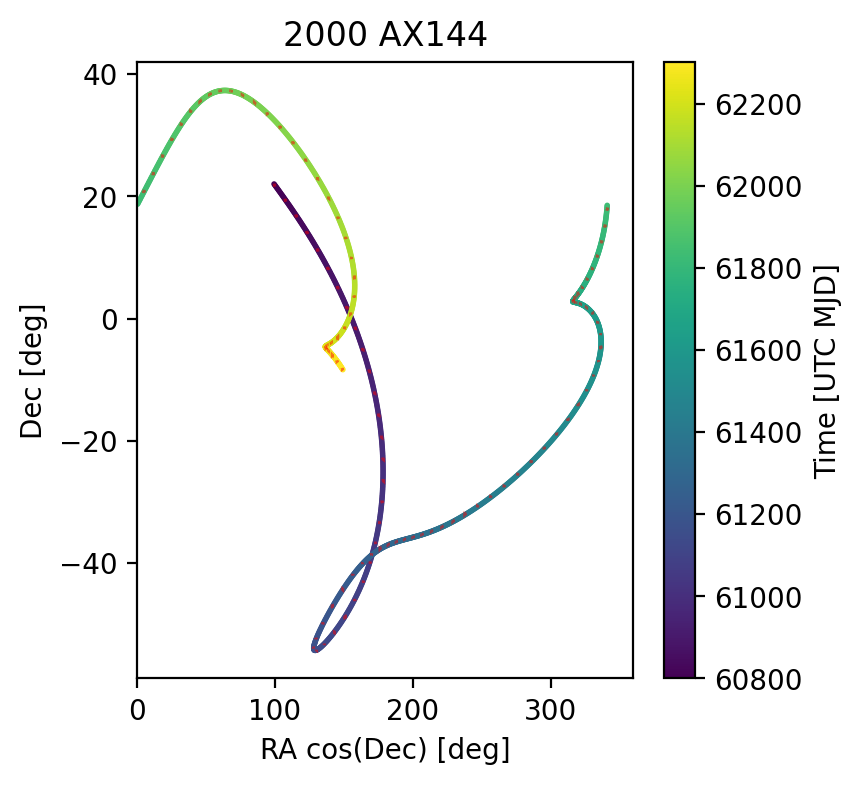

In [10]:
plt.figure(figsize=(4, 4), dpi=200)
plt.scatter(obs[:, 0]*cos_dec, obs[:, 1], c = t_eval, cmap='viridis', s=1)
# plot vector field of ra, dec rates
for i in range(0, num_pts, 14):
    plt.arrow(obs[i, 0]*cos_dec[i], obs[i, 1], obs_dot[i, 0]*cos_dec[i], obs_dot[i, 1], head_width=0.1, head_length=0.1, fc='r', ec='r', alpha=0.5)
plt.xlabel('RA cos(Dec) [deg]')
plt.ylabel('Dec [deg]')
plt.xlim([0, 360])
plt.colorbar(label=f'Time [{timescale} MJD]')
plt.title(f'{body_id}')
plt.show()

In [11]:
# get states for sun and earth
if t_eval_utc:
    # GRSS can handle UTC evaluation times naturally but we need TDB for querying the ephemeris
    t_eval_tdb = Time(t_eval, format='mjd', scale='utc').tdb.mjd
else:
    t_eval_tdb = t_eval

# need to memory map the ephemeris used in the propagation simulation
app_states_full = np.array(prop_sim.xIntegEval)
app_states = app_states_full[:,:6]
prop_sim.map_ephemeris()
sun_states = np.array([prop_sim.get_spiceBody_state(t, "Sun") for t in t_eval_tdb])
earth_states = np.array([prop_sim.get_spiceBody_state(t, "Earth") for t in t_eval_tdb])
observer_states = np.array(prop_sim.xObserver)
body_states = np.array([observer_states[i] + app_states[i] for i in range(num_pts)])
# unmap the ephemeris
prop_sim.unmap_ephemeris()

In [12]:
# compute RA and Dec uncertainties
app_stms = app_states_full[:,6:]
radec_sigs = np.zeros((num_pts, 2))
for i in range(num_pts):
    stm = np.array(prop.reconstruct_stm(app_stms[i]))[:6]
    full_partial = obs_partials[i].reshape(2, 6) @ stm
    radec_cov = full_partial @ cov @ full_partial.T
    if np.any(np.diag(radec_cov) < 0):
        print(f"Negative variance at time {t_eval[i]}")
        print(radec_cov)
    radec_sigs[i] = np.sqrt(np.diag(radec_cov))

In [13]:
# compute heliocentric and geocentric distances
helio_pos = body_states[:,:3] - sun_states[:,:3]
geo_pos = body_states[:,:3] - earth_states[:,:3]
helio_dist = np.linalg.norm(helio_pos, axis=1)
geo_dist = np.linalg.norm(geo_pos, axis=1)
# compute solar phase angle w.r.t observer, not geocenter (Observer-Target-Sun angle)
pos = app_states[:,:3]
r = np.linalg.norm(pos, axis=1)
phase_angle = np.arccos(np.sum(helio_pos*pos, axis=1)/(helio_dist*r))*180.0/np.pi
# compute elongation angle w.r.t geocenter, not observer (Sun-Earth-Target angle)
earth_sun_pos = sun_states[:,:3] - earth_states[:,:3]
earth_sun_dist = np.linalg.norm(earth_sun_pos, axis=1)
elongation = np.arccos(np.sum(geo_pos*earth_sun_pos, axis=1)/(geo_dist*earth_sun_dist))*180.0/np.pi

In [14]:
sig_fac = 3
data = {
    f'Time [{timescale}]': Time(t_eval, format='mjd', scale=timescale.lower()).iso,
    f'Time [{timescale} MJD]': t_eval,
    'RA [deg]': obs[:, 0],
    'Dec [deg]': obs[:, 1],
    'RADotCosDec [deg/day]': obs_dot[:, 0],
    'DecDot [deg/day]': obs_dot[:, 1],
    f'RA{sig_fac}Sig [arcsec]': radec_sigs[:, 0]*sig_fac,
    f'Dec{sig_fac}Sig [arcsec]': radec_sigs[:, 1]*sig_fac,
    'Phase [deg]': phase_angle,
    'Elongation [deg]': elongation,
    'ObsDist [AU]': r,
    'HelioDist [AU]': helio_dist,
    'GeoDist [AU]': geo_dist,
}
ephem = pd.DataFrame(data)

In [15]:
ephem.head()

,Time [UTC],Time [UTC MJD],RA [deg],Dec [deg],RADotCosDec [deg/day],DecDot [deg/day],RA3Sig [arcsec],Dec3Sig [arcsec],Phase [deg],Elongation [deg],ObsDist [AU],HelioDist [AU],GeoDist [AU]
0,2025-05-05 00:00:00.000,60800.0,107.163073,22.025870,0.431788,-0.174320,0.015143,0.013506,25.064391,61.467096,2.376216,2.091455,2.376233
1,2025-05-06 00:00:00.000,60801.0,107.633193,21.852868,0.432522,-0.174672,0.015081,0.013474,24.922675,60.952622,2.387604,2.092724,2.387620
2,2025-05-07 00:00:00.000,60802.0,108.103458,21.679499,0.433225,-0.175042,0.015021,0.013444,24.779410,60.439933,2.398948,2.093999,2.398964
3,2025-05-08 00:00:00.000,60803.0,108.573840,21.505747,0.433900,-0.175429,0.014962,0.013414,24.634634,59.928993,2.410248,2.095282,2.410264
4,2025-05-09 00:00:00.000,60804.0,109.044314,21.331592,0.434549,-0.175834,0.014905,0.013386,24.488381,59.419767,2.421504,2.096571,2.421520


In [16]:
ephem.tail()

,Time [UTC],Time [UTC MJD],RA [deg],Dec [deg],RADotCosDec [deg/day],DecDot [deg/day],RA3Sig [arcsec],Dec3Sig [arcsec],Phase [deg],Elongation [deg],ObsDist [AU],HelioDist [AU],GeoDist [AU]
1496,2029-06-09 00:00:00.000,62296.0,149.566111,-7.955101,0.312533,-0.096813,0.022478,0.025533,24.743568,77.309874,2.371861,2.366113,2.371893
1497,2029-06-10 00:00:00.000,62297.0,149.887379,-8.053079,0.314880,-0.098223,0.022451,0.025415,24.667322,76.737535,2.384615,2.367795,2.384647
1498,2029-06-11 00:00:00.000,62298.0,150.211008,-8.152475,0.317177,-0.099628,0.022425,0.025298,24.588772,76.167909,2.397337,2.369476,2.397369
1499,2029-06-12 00:00:00.000,62299.0,150.536950,-8.253284,0.319424,-0.101027,0.022402,0.025183,24.507962,75.600961,2.410026,2.371156,2.410057
1500,2029-06-13 00:00:00.000,62300.0,150.865158,-8.355498,0.321620,-0.102417,0.022382,0.025069,24.424939,75.036656,2.422679,2.372835,2.422710


In [17]:
# $$SOE
# 2460800.500000000 = A.D. 2025-May-05 00:00:00.0000 TDB 
#  X =-1.375405971604993E+00 Y = 1.452238731911988E+00 Z = 6.083936407786638E-01
#  VX=-9.408294601297360E-03 VY=-3.993502278394999E-03 VZ=-7.278873347514874E-03
#  LT= 1.207467624394402E-02 RG= 2.090665382918063E+00 RR= 1.297331298484680E-03
# 2462300.500000000 = A.D. 2029-Jun-13 00:00:00.0000 TDB 
#  X =-2.236167813449527E+00 Y = 2.438995927529591E-01 Z =-7.522188357601051E-01
#  VX=-3.170413129176071E-04 VY=-8.541667761205981E-03 VZ=-7.131577570494590E-03
#  LT= 1.369877791142492E-02 RG= 2.371869869559666E+00 RR= 1.682282539826689E-03
# $$EOE
x_jpl = np.array([
    -2.236167813449527E+00, 2.438995927529591E-01, -7.522188357601051E-01,
    -3.170413129176071E-04, -8.541667761205981E-03, -7.131577570494590E-03
])
x_grss_full = prop_sim.xInteg
stm_grss = np.asarray(prop.reconstruct_stm(x_grss_full[6:]))
x_grss = x_grss_full[:6]
cov_grss = stm_grss @ cov @ stm_grss.T
sig_grss = np.sqrt(np.diag(cov_grss))
diff = (x_jpl - x_grss)/sig_grss
print(f'State comparison with JPL Horizons (sigmas): {diff}')

State comparison with JPL Horizons (sigmas): [ 0.000597   -0.00702586 -0.00771393  0.00805047 -0.00153544  0.00701816]
